<a href="https://colab.research.google.com/github/lkidane/Deep-learning-/blob/NLP/SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA On synthetica data


Run this cell to generate and display our synthetic data.

Imagine that you are only given the rotated data, and would like to find the angle by which it has been rotated. We can do this by identifying the principal directions !

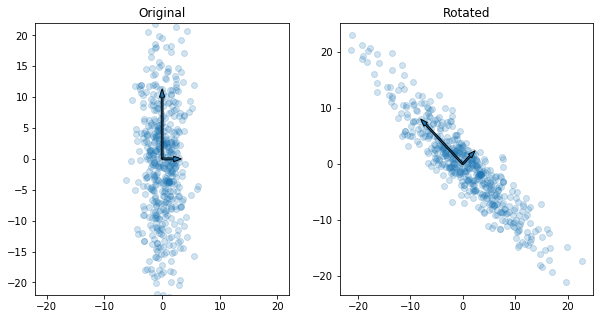

In [0]:
from matplotlib import pyplot as plt
import torch
import math

cov = torch.FloatTensor([
    [2, 0],
    [0, 10]
])
# generate the original data
data = torch.randn(500, 2) @ cov
plt.figure(figsize=(10, 5))
plt.subplot(121)
orig = plt.scatter(data[:, 0], data[:, 1] ,alpha=0.2)
plt.xlim([-22, 22])
plt.ylim([-22, 22])
plt.title("Original")


directions = torch.FloatTensor([
    [0, 10],
    [2, 0]
])


a = plt.arrow(0, 0, 0, 10, width=0.3)
plt.arrow(0, 0, 2, 0, width=0.3, facecolor=a.get_facecolor())

# generate a random rotation of this data
theta = torch.FloatTensor([math.pi / 4])
rotation_matrix = torch.FloatTensor([
    [torch.cos(theta), torch.sin(theta)],
    [-torch.sin(theta), torch.cos(theta)]
])
rotated_directions = directions @ rotation_matrix
rotated_data = data @ rotation_matrix
plt.subplot(122)
rotated = plt.scatter(rotated_data[:, 0], rotated_data[:, 1],alpha=0.2)

b = plt.arrow(0, 0, rotated_directions[0, 0], rotated_directions[0, 1], width=0.3)
plt.arrow(0, 0, rotated_directions[1, 0], rotated_directions[1, 1], width=0.3, facecolor=b.get_facecolor())
plt.title("Rotated")
plt.show()

Here, we generated the data, so we know what rotation we applied. Now imagine that you were only given the rotated data (the *rotated_data* tensor) and you want to retrieve the angle of the rotation $\theta$.

We can do this by identifying the principal directions using the PCA !


Let $X\in\mathbb{R}^{N\times d}$ be a centered dataset. Then $\Sigma=\frac{1}{N}X^\top X$ is its empirical covariance.

The [Eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of this matrix reveals the _principal directions_ of the dataset.

For $\Sigma=U\cdot\textrm{Diag}(S)\cdot U^\top$. The principal directions are the columns of $U$, while the strength of these directions are represented by $S$.


In the next cell:
- compute the empirical covariance and its eigendecomposition (use [symeig](https://pytorch.org/docs/stable/torch.html#torch.symeig)).
- display the directions (the two columns of $U$) multiplied by the corresponding values in $\sqrt{S}$.

In the following, we will see different, practical uses of the PCA.

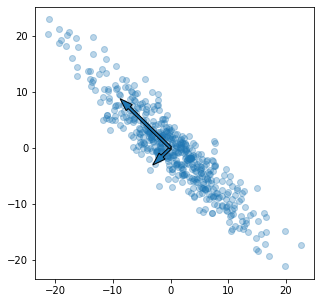

In [0]:
empirical_covariance = rotated_data.T @ rotated_data / len(rotated_data)
s, u = torch.symeig(empirical_covariance, eigenvectors=True)

plt.figure(figsize=(5,5))
plt.scatter(rotated_data[:, 0], rotated_data[:, 1], alpha=0.3)
for length, vector in zip(s, u):
    plt.arrow(0, 0, math.sqrt(length)*vector[0], math.sqrt(length)*vector[1], width=0.5)

plt.show()

# MNIST

## The dataset

In [0]:
import torch
from torchvision import datasets, transforms

dataset = datasets.MNIST('../data', train=True, download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

all_examples = torch.cat([x[0] for x in dataset], 0).view(len(dataset), -1)
all_labels = torch.LongTensor([x[1] for x in dataset])

0it [00:00, ?it/s]

9920512it [00:01, 8546829.92it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130291.92it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 2345354.82it/s]                           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


8192it [00:00, 48720.22it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


Let's display an example of this dataset. Additionally, we display the mean of the dataset, and the first image of the centered dataset.

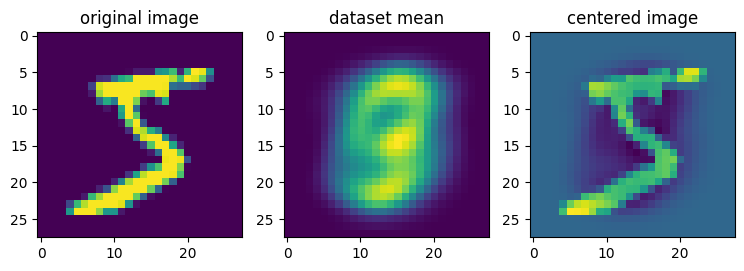

In [0]:
from matplotlib import pyplot as plt

plt.figure(dpi=100, figsize=(9,3))
plt.subplot(131)
plt.imshow(all_examples[0].view(28,28).numpy())
plt.title("original image")
plt.subplot(132)
plt.imshow(torch.mean(all_examples, 0).view(28,28).numpy())
plt.title("dataset mean")
plt.subplot(133)
plt.imshow((all_examples[0] - torch.mean(all_examples, 0)).view(28,28).numpy())
plt.title("centered image")
plt.show()

## Linear dimensionality reduction : PCA

Let $X\in\mathbb{R}^{N\times d}$ be a centered dataset. Then $\Sigma=\frac{1}{N}X^\top X$ is the empirical covariance.

The [Eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of this matrix reveals the _principal directions_ of the dataset.

For $\Sigma=U\cdot\textrm{Diag}(S)\cdot U^\top$. The principal directions are the columns of $U$, while the strength of these directions are represented by $S$.


In the next cell:
- compute the empirical covariance and its eigendecomposition.
- Plot the eigenvalues cumulative distribution : $cs(i) = \frac{\sum_{j=1}^i s_j}{\sum_{i=1}^n s_i}$.
- Find the number of eigenvalues required such that $\sum_{j=1}^i s_j$ makes up more than $80\%$ of the spectrum.

80% reached at eigenvalue number 35


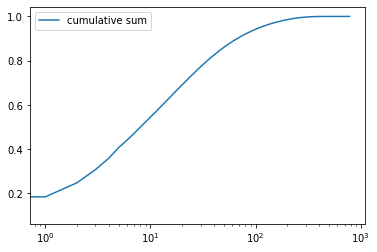

In [0]:
import numpy as np

# smaller dataset :
n_points = 500
data = all_examples[:n_points]
labels = np.array(all_labels)[:n_points]

# center dataset, we remove the mean over columns:
centered_data = data - torch.mean(data, 0)

# compute the empirical covariance using the CENTERED data
empirical_covariance = centered_data.T @ centered_data / len(dataset)
s, u = torch.symeig(empirical_covariance, eigenvectors=True)

# reverse the s since symeig returns them in ascending order
s = s.numpy()[::-1]
distribution = np.cumsum(s) / np.sum(s)
eighty = np.searchsorted(distribution, 0.8, side='right')
print(f"80% reached at eigenvalue number {eighty}")

plt.figure()
plt.plot(distribution, label="cumulative sum")

# we use log scale for x to better see how quickly the curve rises
plt.xscale('log')
plt.legend()
plt.show()

Project the first 500 examples of the dataset on the top 2 eigenvectors of the empirical covariance. How much of the variance is still explained ?

Use a scatter plot and color the points using the labels.

Are the different labels well separated ? **images for 0 and 1 are well separated, the others, not so much**

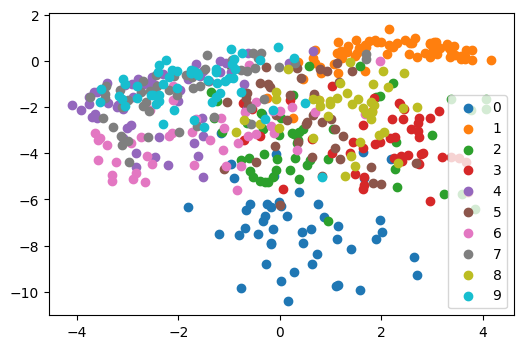

In [0]:
transformed = (data @ u[:, -2:]).numpy()
plt.figure(dpi=100)
for l in range(10):
  these_points = transformed[labels == l]
  plt.scatter(these_points[:, 0], these_points[:, 1], label=str(l))
plt.legend()
plt.show()


What information was kept ? What information was lost when we projected ?
We can project the data back to the original space to understand this ! In this cell, I plot the information lost when we use 2, 15 and 35 eigenvectors.

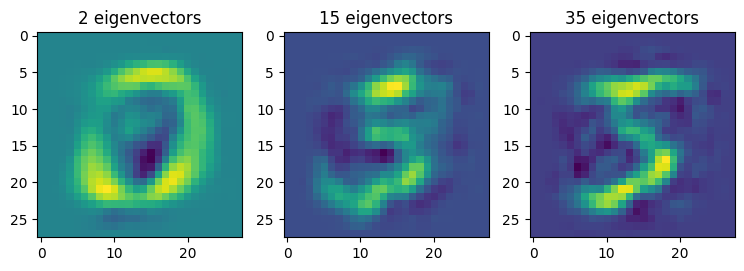

In [0]:
img_id = np.where(labels==5)[0][0]
plt.figure(dpi=100, figsize=(9,3))
for i, vectors_kept in enumerate([-2, -15, -35]):
    plt.subplot(131 + i)
    plt.imshow((data[img_id] @ u[:, vectors_kept:] @u[:, vectors_kept:].T).view(28,28))
    plt.title(f"{-vectors_kept} eigenvectors")
plt.show()

The same thing can be done with scikit learn. Let's use this cell to encapsulate our plot method.

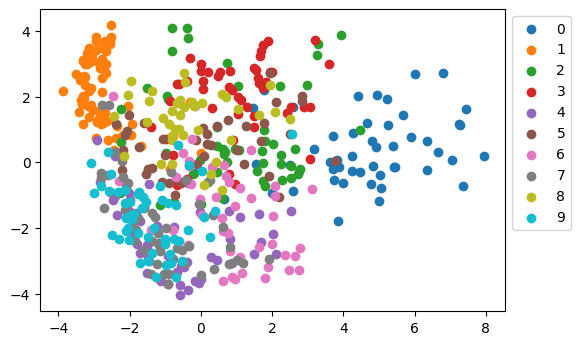

In [0]:
def display_mnist(reduced, labels):
  plt.figure(dpi=100)
  for l in range(10):
    these_points = reduced[labels == l]
    plt.scatter(these_points[:, 0], these_points[:, 1], label=str(l))
  plt.legend(bbox_to_anchor=(1, 1), loc=2)
  plt.show()

from sklearn.decomposition import PCA
transformed = PCA(n_components=2).fit_transform(data.numpy())
display_mnist(transformed, labels)



Try to compute the PCA without centering the dataset first. What happens ?
**Things are not so well scattered ! The first principal component is the mean of the dataset rather than an interesting direction.**

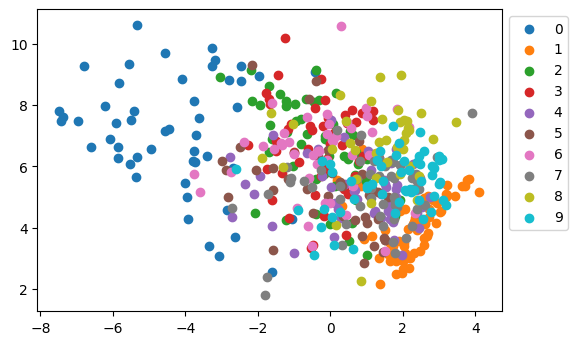

In [0]:
# compute the empirical covariance WITHOUT centering the data
empirical_covariance = data.T @ data / len(dataset)
s, u = torch.symeig(empirical_covariance, eigenvectors=True)

transformed = (data @ u[:, -2:]).numpy()
display_mnist(transformed, labels)

The principal directions can be interpreted as images themselves, let's display them.

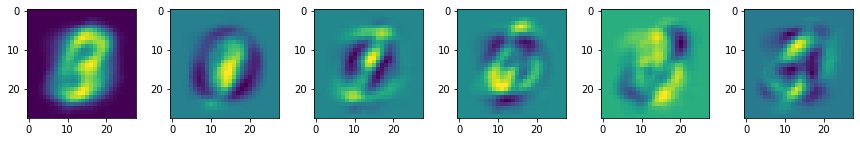

In [0]:
plt.figure(figsize=(15, 2))
for i in range(1, 7):
  plt.subplot(160 + i)
  plt.imshow(u[:, -i].view(28, 28))
plt.show()

Notice how the eigenvectors capture particular shapes of the numbers.

## PCA on learned representations


In [0]:
import torch.nn.functional as F
from torch import nn
from torch import optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

device = 'cuda:0'

model = Net().to(device)

train_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=128, shuffle=True, num_workers=1, pin_memory=True
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
  losses = []
  for batch_idx, (batch, target) in enumerate(train_loader):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(batch)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, np.mean(losses)))


Train Epoch: 0 	Loss: 0.293220
Train Epoch: 1 	Loss: 0.105456
Train Epoch: 2 	Loss: 0.077284
Train Epoch: 3 	Loss: 0.064857
Train Epoch: 4 	Loss: 0.059876
Train Epoch: 5 	Loss: 0.050994
Train Epoch: 6 	Loss: 0.045366
Train Epoch: 7 	Loss: 0.045304
Train Epoch: 8 	Loss: 0.041315
Train Epoch: 9 	Loss: 0.036611


Define a function that applies the neural net (without dropout) we've learned to a batch of examples, and returns all intermediate representations.


Using the reduced dataset used earlier, display a PCA of each of the intermediate representations, what do you notice ?

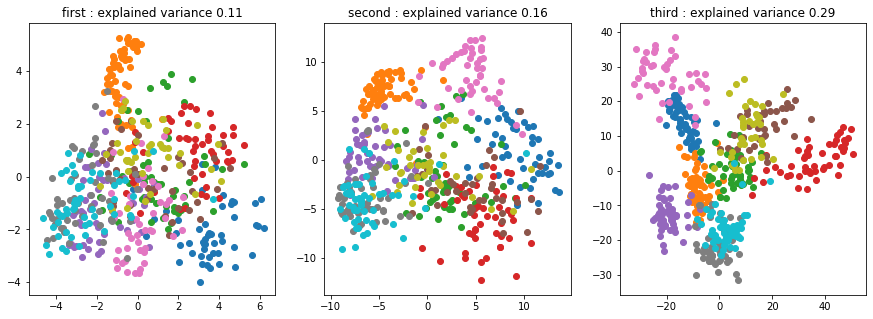

In [0]:
def transform(model, x):
  x = model.conv1(x)
  x_first = F.relu(x)
  x = model.conv2(x_first)
  x = F.max_pool2d(x, 2)
  x_second = torch.flatten(x, 1)
  x = model.fc1(x_second)
  x_third = F.relu(x)
  return {
      'first': x_first.view(x.shape[0], -1).detach().cpu(),
      'second': x_second.view(x.shape[0], -1).detach().cpu(),
      'third': x_third.view(x.shape[0], -1).detach().cpu(),
  }


from sklearn.decomposition import PCA

data = all_examples[:500]
labels = all_labels[:500]
transformed = transform(model, data.view(-1, 1, 28, 28).to(device))
plt.figure(figsize=(15,5))
for i,k in enumerate(['first', 'second', 'third']):
    plt.subplot(131+i)
    pca = PCA(n_components=2)
    pca.fit(transformed[k])
    plt.title(f"{k} : explained variance {np.sum(pca.explained_variance_ratio_):.2f}")
    pcaed = pca.transform(transformed[k])

    for l in range(10):
        points = pcaed[all_labels[:500] == l]
        plt.scatter(points[:, 0], points[:, 1], label=l)


## Non-Linear dimensionality reduction : T-SNE

T-SNE learns representations of points such that points that are close in the original space will be close in the target space.

It is more flexible than the PCA, since the transformation isn't necessarily linear.

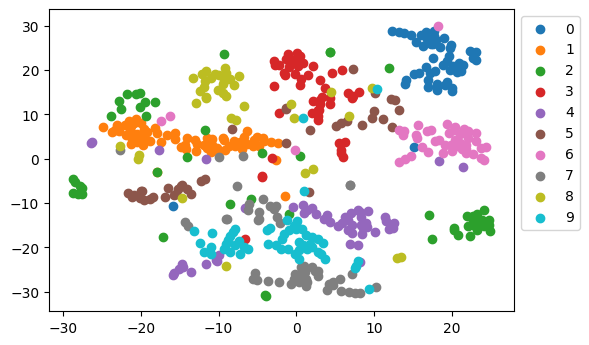

In [0]:
from sklearn.manifold import TSNE

transformed = TSNE(n_components=2).fit_transform(data)
display_mnist(transformed,labels)

Not too bad, clusters appear more clearly than in the PCA visualization. Remember that this is completely unsupervised, the only information represented in a T-SNE plot is the nearest neighbors of each points.

Now let's plot the T-SNE representations for the intermediate layer of our neural net. 

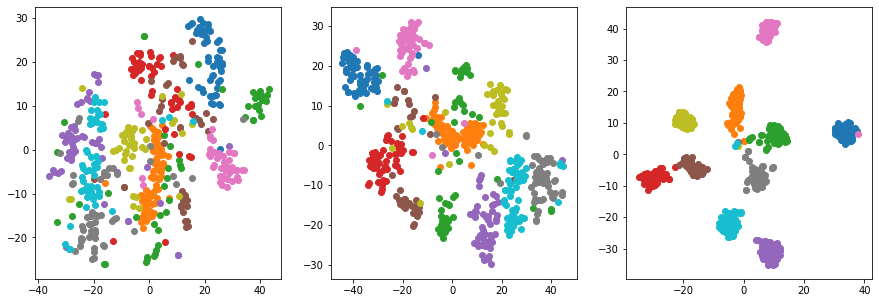

In [0]:
transformed = transform(model, data.view(-1, 1, 28, 28).to(device))
plt.figure(figsize=(15,5))
for i,k in enumerate(['first', 'second', 'third']):
    plt.subplot(131+i)
    tsneed = TSNE(n_components=2).fit_transform(transformed[k])
    for l in range(10):
        points = tsneed[all_labels[:500] == l]
        plt.scatter(points[:, 0], points[:, 1], label=l)

# Word vectors

Word vectors often come up in NLP applications. They are learned by trying to predict a word given it's context. This means that words that occur in similar context will have similar representations. Let's observe these representations with our tools.

Start by loading [FastText](https://fasttext.cc/) words embeddings for 1M english words. 



In [0]:
import torch
embeddings = torch.load('drive/My Drive/AMMI_DIY/session_2/embeddings.torch')


Now let's plot a PCA of all words

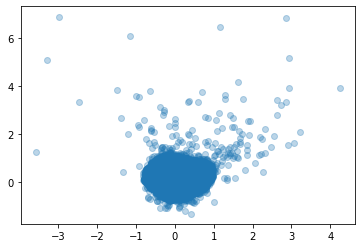

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
transformed = PCA(n_components=2).fit_transform(embeddings['vectors'])

plt.figure()
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.3)
plt.show()

Not great. Two dimensions are not enough to describe the variety of one million words.

Let's work with less words.

Load a list of countries and capitals. Build an array containing all vectors corresponding to either countries or capitals. Ignore those that aren't in the loaded word vectors.


In [0]:
f = open('drive/My Drive/AMMI_DIY/session_2/countries_capitals')
to_project = []
pairs = []
for line in f:
    country, capital = [x.strip() for x in line.split('-', 1)]
    
    if country in embeddings['word_id'] and capital in embeddings['word_id']:
        pairs.append((country, len(to_project), capital, len(to_project) + 1))
        word_id = embeddings['word_id'][country]
        to_project.append(embeddings['vectors'][word_id][None, :])

        word_id = embeddings['word_id'][capital]
        to_project.append(embeddings['vectors'][word_id][None, :])

Compute a PCA of these vectors and display a scatter plot. Plot an arrow going from each country to its capital, what do you notice ?

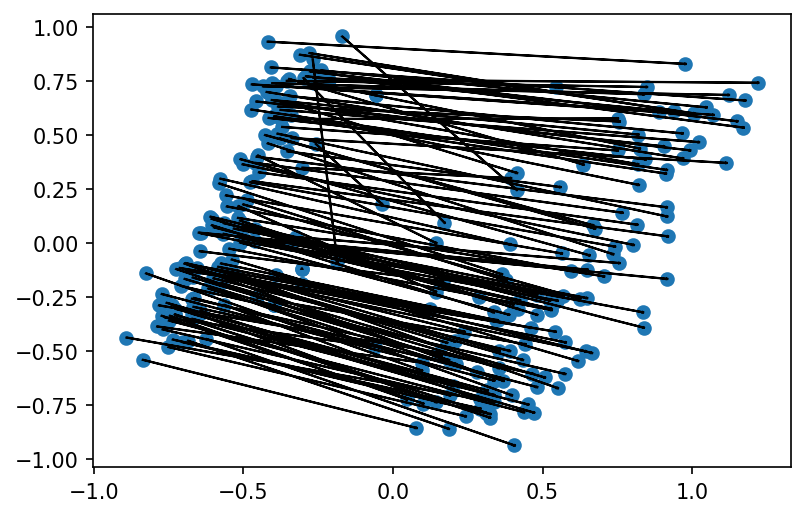

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)
plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1])
plt.show()

But why use a PCA ? Isn't t-SNE strictly better ? Let's try with t-SNE.

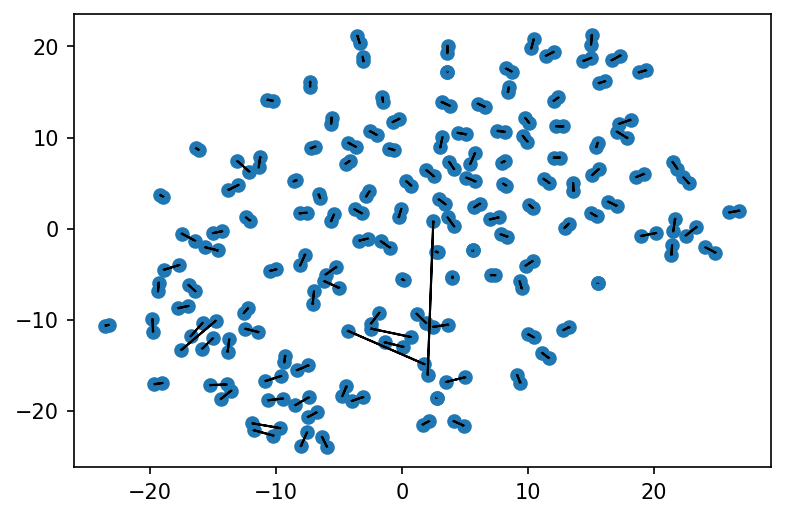

In [0]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

full_vectors=torch.cat(to_project)
transformed = TSNE(n_components=2).fit_transform(full_vectors)

plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1])
plt.show()

The take away from the two methods are wildly different. From the TSNE plot, we learn that the representation of a capital is close to the representation of its country.

However, letting $U$ be the matrix of word embeddings, with $P$ the projection from the PCA, we see that there exist a vector $v$ such that $$\forall (\textrm{country}, \textrm{capital}), P(U_{\textrm{country}} - U_{\textrm{capital}}) \approx v.$$

**The difference between a country and it's capital is constant and does not depend on the pair chosen !**

This $v$ can be interpreted as the projection of a vector $\tilde{v}$ in the original (non-projected) space. However, since $P$ is not invertible, we have no guarantee that 
$$\forall (\textrm{country}, \textrm{capital}), U_{\textrm{country}} - U_{\textrm{capital}} \approx \tilde{v}.$$

Let's try !
Let $\tilde{v} = U_{Madrid} - U_{Spain}$ and compute $U_{France} + \tilde{v}$, find its 5 nearest neighbors. Try with $U_{Rwanda} + \tilde{v}$. 

In [0]:
normed = embeddings['vectors'] / torch.norm(embeddings['vectors'], 2, 1, keepdim=True)

v = normed[embeddings['word_id']['Madrid']] - normed[embeddings['word_id']['Spain']]
modified_france = normed[embeddings['word_id']['France']] + v

distances = torch.norm(normed - modified_france[None, :], 2, 1)
distances, ids = torch.sort(distances)

for i, d in zip(ids[:5], distances[:5]):
    print(embeddings['words'][i], d)

Paris tensor(0.5785)
France tensor(0.7212)
Madrid tensor(0.7652)
Toulouse tensor(0.8419)
Lille tensor(0.8441)


In the next cell, plot the countries and capitals transformed by a PCA, then also apply the PCA to words in ['Capital', 'Dog', 'Computer', 'Pizza', 'City', 'Country']. What do you notice ? **The word embedding for Capital is aligned with the vector obtained by substracting a capital and its country. The reverse works for the word embeddinf for Country. However, the word embeddings for the other words are not aligned.**

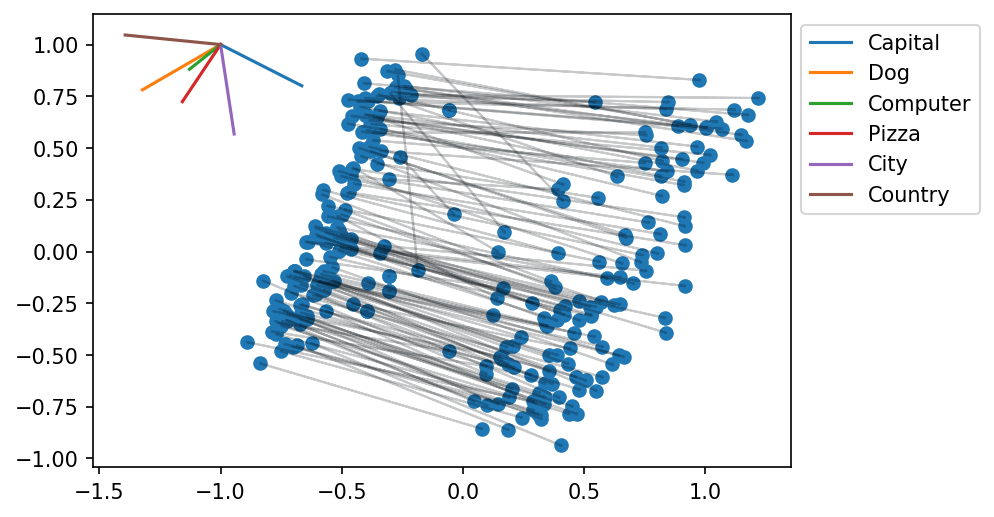

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)
words = ['Capital', 'Dog', 'Computer', 'Pizza', 'City', 'Country']
vectors_to_plot = [
    pca.transform(embeddings['vectors'][embeddings['word_id'][x]][None, :])
    for x in words
]
plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1], alpha=0.2)
for v, w in zip(vectors_to_plot, words):
    x = v[0, 0]
    y = v[0, 1]
    plt.plot([-1, -1 + x], [1, 1 +y], label=w)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

Since the PCA is simpler, the relations it reveals can be understood mathematically. Here, we've rediscovered that word vectors can be used to answer analogies:
The answer to "A is to B as C is to ..." can be computed by finding the nearest neighbor of $vec(b) - vec(a) + vec(c)$.

# Back to the Logistic Regression

Since visualizations are in 2D, lots of information is lost. There are other tools to probe the information contained in embeddings.

For example, we can try to learn a linear classifier that separates countries from other words. If we obtain good performances, then we know that there exists a hyperplane in the original space that separates the country words from the others.


First, we build our dataset : we will need a train, validation and test set.

In [0]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import metrics
import torch

dataset = torch.load('drive/My Drive/AMMI_DIY/session_2/country_classif.torch')
Cs = np.logspace(-2, 1, num=50)
perfs = []
for C in Cs:
    model = LinearSVC(C=C, loss='hinge')
    model.fit(dataset['train']['vectors'].numpy(), dataset['train']['labels'].numpy())
    
    predictions = model.decision_function(dataset['valid']['vectors'].numpy())
    precision, recall, thresholds = metrics.precision_recall_curve(
        dataset['valid']['labels'].numpy(), predictions
    )
    
    perfs.append(metrics.auc(recall, precision))
    

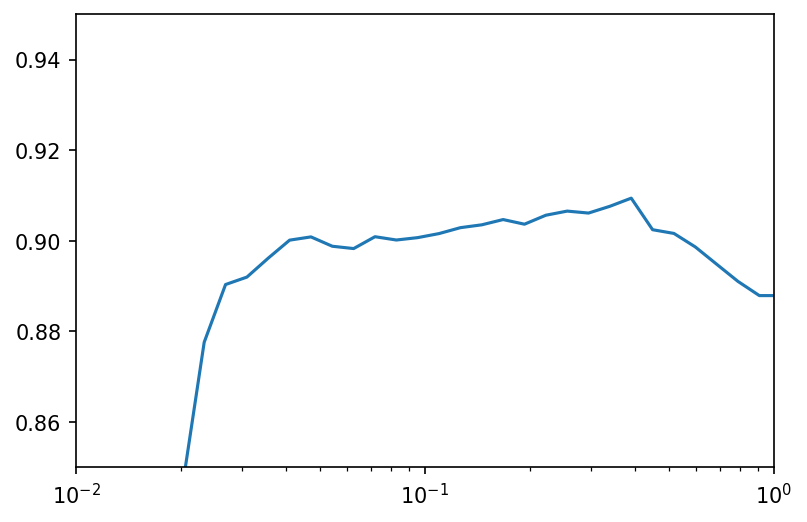

In [0]:
from matplotlib import pyplot as plt
plt.figure(dpi=150)
plt.plot(Cs, perfs)
plt.xscale('log')
plt.xlim([1e-2, 1])
plt.ylim([0.85,0.95])
plt.show()

In order to obtain the best classifier, we select based on the validation loss. Select the corresponding parameters and retrain. Then we save the coefficients and intercepts

In [0]:
best_c = Cs[np.argmax(perfs)]
best_regression = LinearSVC(C=best_c, loss='hinge')
best_regression.fit(dataset['train']['vectors'].numpy(), dataset['train']['labels'].numpy())

coeffs = best_regression.coef_
intercept = best_regression.intercept_

Since the PCA is linear, we can display the projection of the hyperplane !

For P the projection : 
$<w, x> - b = 0$ becomes $<Pw, Px> - b = 0$

In [0]:
f = open('drive/My Drive/AMMI_DIY/session_2/countries_capitals')
to_project = []
pairs = []
for line in f:
    country, capital = [x.strip() for x in line.split('-', 1)]
    
    if country in embeddings['word_id'] and capital in embeddings['word_id']:
        pairs.append((country, len(to_project), capital, len(to_project) + 1))
        word_id = embeddings['word_id'][country]
        to_project.append(embeddings['vectors'][word_id][None, :])

        word_id = embeddings['word_id'][capital]
        to_project.append(embeddings['vectors'][word_id][None, :])

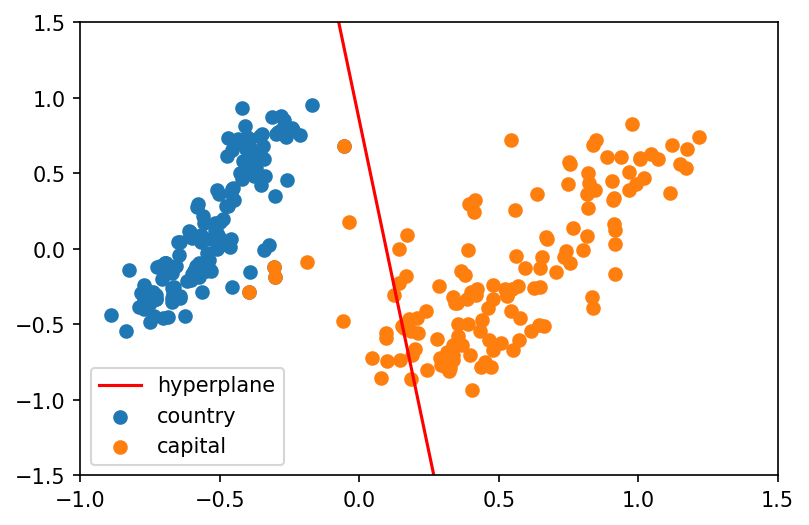

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)


w = pca.transform(coeffs[:])
xx = np.linspace(-1.5, 1.5)
a = -w[0, 0] / w[0, 1]
yy = a * xx - intercept

plt.figure(dpi=150)
plt.scatter(transformed[::2, 0], transformed[::2, 1], label="country")
plt.scatter(transformed[1::2, 0], transformed[1::2, 1], label="capital")
plt.plot(xx, yy, 'r', label="hyperplane")
plt.ylim([-1.5, 1.5])
plt.xlim([-1, 1.5])
plt.legend()
plt.show()

Notice that this hyperplane is not great ! However, in the dataset we used, we only had **7** positive examples, and **5000** negative examples.